<a href="https://colab.research.google.com/github/isc06114/AnalysisOfCoinCorrelation/blob/main/Get_Coin_Data_From_Api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

cal(기간 단위, 횟수, 받아올 코인 갯수) - 코인 정보를 불러오기(시가 기준 가격변동률, 시가 기준 가격, 거래 총액 == Stock.dod, price, volume)


compareDataPlot(기간 단위, 횟수, 첫번째 코인 ticker, 2번째 코인 ticker)


calshift(기간 단위, 횟수, 가저올 코인 갯수) X


calDodnPrice(모든 Stock, 비교할 Stock) - 코인정보를 이용한 피어슨 상관계수 분석값과 |r| >= 0.8 인 모든 코인의 tickers 출력


calVolume(모든 Stock, 비교할 Stock) - 거래량의 피어슨 상관계수 분석과 |r| >= 0.8인 모든 tickers 출력




In [ ]:
import requests
import json
import numpy as np
from datetime import datetime
import pandas as pd
!pip install pyupbit
!pip install -U pyupbit
import pyupbit
import scipy.stats as stats
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from google.colab import drive
drive.mount('/content/drive')
f_path = 'drive/MyDrive/coin_data_analysis/'
f_2YearDay50_corr = "f_2YearDay50_corr.csv"
f_2YearDay50_dod_list = "f_2YearDay50_dod_list.csv"
f_2YearDay50_price_list = "f_2YearDay50_price_list.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


주식 구조체 코드

In [ ]:
from dataclasses import dataclass, field
from typing import List
@dataclass
class Stock:
  ticker:str = None
  dod:List[float] = field(default_factory=list)
  price:List[float] = field(default_factory=list)
  volume:List[float] = field(default_factory=list)

<h1>----------------------------------

pyupbit로부터 DataFrame 형식의 데이터를 받아 시작가와 전일 대비 시가 상승률을 저장

In [ ]:
def cal(interv,coun, num):
  interval = interv                                                               #데이터 조회 단위(day/minute1/minute3/minute5/minute10/minute15/minute30/minute60/minute240/week/month)
  to = '2023-10-05 11:20'                                                      #기준 시간
  count = coun                                                                #기준 시간으로부터 조회단위 만큼 가져올 데이터 개수 - 1년기준:365
  comparison_stocks = []
  stocks = []
  tickers = pyupbit.get_tickers(fiat = "KRW")                                     #거래 가능한 시장(KRW/BTC/USDT)
  stocknum = num                                                                #받아올 코인 개수, 전부받으려면 len(tickers) 사용
  comparison_stocks_tickers = []         #'KRW-BTC', 'KRW-ETH', 'KRW-XRP'                  #비교 기준이 될 코인 ticker


  for i in range(stocknum):
    df = pyupbit.get_ohlcv(ticker = tickers[i], interval = interval, to = to, count = count)
    open_price_sample = df[['open']].values.flatten()
    volume = df[['volume']].values.flatten()
    dod = []
    for j in range(1,count):
      dod.append((open_price_sample[j-1] - open_price_sample[j])/open_price_sample[j-1])
    stocks.append(Stock(tickers[i], dod, open_price_sample, volume))
    comparison_stocks.append(Stock(tickers[i],dod, open_price_sample, volume))
  return stocks, comparison_stocks
                                                                                          #dod는 (시가 - 종가)/시가, 즉 전일 기준 가격 증감량을 의미함, price는 시작가를 비교

In [ ]:
def calSecond(interv,coun, num):
  interval = interv                                                               #데이터 조회 단위(day/minute1/minute3/minute5/minute10/minute15/minute30/minute60/minute240/week/month)
  to = '2023-10-05 11:20'                                                      #기준 시간
  count = coun                                                                #기준 시간으로부터 조회단위 만큼 가져올 데이터 개수 - 1년기준:365
  comparison_stocks = []
  stocks = []
  tickers = pyupbit.get_tickers(fiat = "KRW")                                     #거래 가능한 시장(KRW/BTC/USDT)
  stocknum = num                                                                #받아올 코인 개수, 전부받으려면 len(tickers) 사용
  comparison_stocks_tickers = []         #'KRW-BTC', 'KRW-ETH', 'KRW-XRP'                  #비교 기준이 될 코인 ticker


  for i in stocknum:
    df = pyupbit.get_ohlcv(i, interval = interval, to = to, count = count)
    open_price_sample = df[['open']].values.flatten()
    volume = df[['volume']].values.flatten()
    dod = []
    for j in range(1,count):
      dod.append((open_price_sample[j-1] - open_price_sample[j])/open_price_sample[j-1])
    stocks.append(Stock(i, dod, open_price_sample, volume))
    comparison_stocks.append(Stock(i,dod, open_price_sample, volume))
  return stocks, comparison_stocks
                                                                                          #dod는 (시가 - 종가)/시가, 즉 전일 기준 가격 증감량을 의미함, price는 시작가를 비교

In [ ]:
def compareDataPlot(interv, coun, first):
  interval = interv                                                               #데이터 조회 단위(day/minute1/minute3/minute5/minute10/minute15/minute30/minute60/minute240/week/month)
  to = '2023-10-05 11:20'                                                      #기준 시간
  count = coun                                                                #기준 시간으로부터 조회단위 만큼 가져올 데이터 개수 - 1년기준:365
  firstStocks = []
  df_first = pyupbit.get_ohlcv(ticker = first, interval = interval, to = to, count = count)
  first_open_price_sample = df_first[['open']].values.flatten()
  first_dod = []
  for j in range(1,count):
    first_dod.append((first_open_price_sample[j-1] - first_open_price_sample[j])/first_open_price_sample[j-1])
  firstStocks = Stock(first, first_dod, first_open_price_sample)



  return firstStocks
                                                                                          #dod는 (시가 - 종가)/시가, 즉 전일 기준 가격 증감량을 의미함, price는 시작가를 비교

각 코인간의 상관관계를 알기 위해 시작가, 전일 대비 시가 상승률에 대한 피어슨 상관계수 계산 및 DataFrame 형식으로 저장

In [ ]:
def calDodnPrice(stocks, comparison_stocks):
  correlation_analysis = []       #저장된 DataFrame 리스트
  dod_list = []
  price_list = []
  for stock in comparison_stocks:
    ticker = []
    cor_dod = []
    cor_price = []
    for compare in stocks:
      ticker.append(compare.ticker)
      cor_dod.append(np.corrcoef(stock.dod,compare.dod)[0,1])
      cor_price.append(np.corrcoef(stock.price,compare.price)[0,1])
    correlation_analysis.append(pd.DataFrame({'ticker': ticker,
                  'cor_dod': cor_dod,
                  'cor_price': cor_price
                  }))
  for df in correlation_analysis:
    df1 = df[(df['cor_dod']>=0.8) | (df['cor_dod']<=-0.8)]
    df1 = df1.sort_values('cor_dod',ascending = False)
    if df1[['ticker']].values.flatten().size == 1:
      pass
    else:
      dod_list.append(df1[['ticker']].values.flatten())
    df1 = df[(df['cor_price']>=0.8) | (df['cor_price']<=-0.8)]
    df1 = df1.sort_values('cor_price',ascending = False)
    if df1[['ticker']].values.flatten().size == 1:
      pass
    else:
      price_list.append(df1[['ticker']].values.flatten())

  return correlation_analysis , dod_list, price_list



In [ ]:
def calDodnPrice(stocks, comparison_stocks):
  correlation_analysis = []       #저장된 DataFrame 리스트
  dod_list = []
  price_list = []
  for stock in comparison_stocks:
    ticker = []
    cor_dod = []
    cor_dod_p = []
    cor_price = []
    for compare in stocks:
      ticker.append(compare.ticker)
      cor_dod.append(stats.pearsonr(stock.dod,compare.dod)[0])
      cor_dod_p.append(stats.pearsonr(stock.dod,compare.dod)[1])
      cor_price.append(stats.pearsonr(stock.price,compare.price))
    correlation_analysis.append(pd.DataFrame({'ticker': ticker,
                  'cor_dod': cor_dod,
                  'cor_dod_p': cor_dod_p,
                  'cor_price': cor_price
                  }))

  return correlation_analysis



In [ ]:
def calDelayedDodnPrice(stocks, comparison_stocks,delay):
  correlation_analysis = []       #저장된 DataFrame 리스트
  dod_list = []
  price_list = []
  for stock in comparison_stocks:
    ticker = []
    cor_dod = []
    cor_price = []
    for compare in stocks:
      ticker.append(compare.ticker)
      cor_dod.append(np.corrcoef(stock.dod[:-delay],compare.dod[delay:])[0,1])
      cor_price.append(np.corrcoef(stock.price[:-delay],compare.price[delay:])[0,1])
    correlation_analysis.append(pd.DataFrame({'ticker': ticker,
                  'cor_dod': cor_dod,
                  'cor_price': cor_price
                  }))
  for df in correlation_analysis:
    df1 = df[(df['cor_dod']>=0.8) | (df['cor_dod']<=-0.8)]
    df1 = df1.sort_values('cor_dod',ascending = False)
    if df1[['ticker']].values.flatten().size == 0:
      pass
    else:
      dod_list.append(df1[['ticker']].values.flatten())
    df1 = df[(df['cor_price']>=0.8) | (df['cor_price']<=-0.8)]
    df1 = df1.sort_values('cor_price',ascending = False)
    if df1[['ticker']].values.flatten().size == 1:
      pass
    else:
      price_list.append(df1[['ticker']].values.flatten())

  return correlation_analysis , dod_list, price_list



In [ ]:
def calVolume(stocks, comparison_stocks):
  correlation_analysis = []       #저장된 DataFrame 리스트
  volume_list = []
  for stock in comparison_stocks:
    ticker = []
    cor_volume = []
    for compare in stocks:
      ticker.append(compare.ticker)
      cor_volume.append(np.corrcoef(stock.volume,compare.volume)[0,1])
    correlation_analysis.append(pd.DataFrame({'ticker': ticker,
                  'cor_volume': cor_volume
                  }))
  for df in correlation_analysis:
    df1 = df[(df['cor_volume']>=0.8) | (df['cor_volume']<=-0.8)]
    df1 = df1.sort_values('cor_volume',ascending = False)
    if df1[['ticker']].values.flatten().size == 1:
      pass
    else:
      volume_list.append(df1[['ticker']].values.flatten())


  return correlation_analysis , volume_list



In [ ]:
def calMeanfulTickerList(stock):
  df = stock
  df1 = df[(df['cor_dod']>=0.8) | (df['cor_dod']<=-0.8)]
  df1 = df1.sort_values('cor_dod',ascending = False)
  return df1

In [ ]:
#데이터 불러오기

f_path = 'drive/MyDrive/coin_data_analysis/700_week/corr/'
f_path_1 = 'drive/MyDrive/coin_data_analysis/700_week/tickers/'
tickers = pyupbit.get_tickers(fiat = "KRW")
for i in range(50):
  downloadedPd = pd.read_csv(os.path.join(f_path, "f_700_week_corr"+tickers[i]+".csv")) #or pd.read_excel(os.path.join(f_path, "data_tmp.xlsx"))
  downloadedPd = downloadedPd.sort_values(by = 'cor_dod',ascending = False)
  print(tickers[i],'와 연관된 코인 갯수:',len(calMeanfulTickerList(downloadedPd))-1)


KRW-BTC 와 연관된 코인 갯수: 2
KRW-ETH 와 연관된 코인 갯수: 1
KRW-NEO 와 연관된 코인 갯수: 3
KRW-MTL 와 연관된 코인 갯수: 0
KRW-XRP 와 연관된 코인 갯수: 0
KRW-ETC 와 연관된 코인 갯수: 1
KRW-SNT 와 연관된 코인 갯수: 9
KRW-WAVES 와 연관된 코인 갯수: 0
KRW-XEM 와 연관된 코인 갯수: 8
KRW-QTUM 와 연관된 코인 갯수: 11
KRW-LSK 와 연관된 코인 갯수: 16
KRW-STEEM 와 연관된 코인 갯수: 9
KRW-XLM 와 연관된 코인 갯수: 0
KRW-ARDR 와 연관된 코인 갯수: 14
KRW-ARK 와 연관된 코인 갯수: 0
KRW-STORJ 와 연관된 코인 갯수: 1
KRW-GRS 와 연관된 코인 갯수: 0
KRW-ADA 와 연관된 코인 갯수: 0
KRW-SBD 와 연관된 코인 갯수: 0
KRW-POWR 와 연관된 코인 갯수: 1
KRW-BTG 와 연관된 코인 갯수: 2
KRW-ICX 와 연관된 코인 갯수: 4
KRW-EOS 와 연관된 코인 갯수: 0
KRW-TRX 와 연관된 코인 갯수: 0
KRW-SC 와 연관된 코인 갯수: 15
KRW-ONT 와 연관된 코인 갯수: 15
KRW-ZIL 와 연관된 코인 갯수: 0
KRW-POLYX 와 연관된 코인 갯수: 4
KRW-ZRX 와 연관된 코인 갯수: 12
KRW-LOOM 와 연관된 코인 갯수: 0
KRW-BCH 와 연관된 코인 갯수: 1
KRW-BAT 와 연관된 코인 갯수: 2
KRW-IOST 와 연관된 코인 갯수: 13
KRW-CVC 와 연관된 코인 갯수: 14
KRW-IQ 와 연관된 코인 갯수: 0
KRW-IOTA 와 연관된 코인 갯수: 6
KRW-HIFI 와 연관된 코인 갯수: 0
KRW-ONG 와 연관된 코인 갯수: 11
KRW-GAS 와 연관된 코인 갯수: 3
KRW-UPP 와 연관된 코인 갯수: 7
KRW-ELF 와 연관된 코인 갯수: 0
KRW-KNC 와 연관된 코인 갯수: 0
KRW-BSV 와 연관

In [ ]:
#데이터 저장하기
f_path = 'drive/MyDrive/coin_data_analysis/700_week/corr/'
f_path_1 = 'drive/MyDrive/coin_data_analysis/700_week/delayMinute3/'
tickers = pyupbit.get_tickers(fiat = "KRW")
D_minute3 = {}
for i in range(50):
  downloadedPd = pd.read_csv(os.path.join(f_path, "f_700_week_corr"+tickers[i]+".csv")) #or pd.read_excel(os.path.join(f_path, "data_tmp.xlsx"))
  downloadedPd = downloadedPd.sort_values(by = 'cor_dod',ascending = False)
  s,c = calSecond('minute3',100,calMeanfulTickerList(downloadedPd).ticker)
  corr_anal, dod_list, price_list = calDelayedDodnPrice(s,c, 1)
  for j in corr_anal:
    j.to_csv(os.path.join(f_path_1, "f_minute3_delayed_"+tickers[i]+j.ticker[0]+".csv"), index=False)




                           open        high         low       close    volume  \
2023-10-05 19:51:00  37596000.0  37598000.0  37594000.0  37598000.0  7.289446   
2023-10-05 19:54:00  37598000.0  37600000.0  37595000.0  37600000.0  3.473668   
2023-10-05 19:57:00  37600000.0  37600000.0  37594000.0  37598000.0  3.059523   
2023-10-05 20:00:00  37600000.0  37600000.0  37595000.0  37595000.0  1.614482   
2023-10-05 20:03:00  37599000.0  37600000.0  37595000.0  37600000.0  3.038341   
2023-10-05 20:06:00  37600000.0  37600000.0  37594000.0  37598000.0  7.459939   
2023-10-05 20:09:00  37598000.0  37598000.0  37593000.0  37598000.0  2.257338   
2023-10-05 20:12:00  37597000.0  37598000.0  37571000.0  37573000.0  4.142122   
2023-10-05 20:15:00  37592000.0  37593000.0  37572000.0  37592000.0  1.906732   
2023-10-05 20:18:00  37592000.0  37592000.0  37571000.0  37591000.0  3.760326   

                            value  
2023-10-05 19:51:00  2.740496e+08  
2023-10-05 19:54:00  1.306038e+08  


In [ ]:
#700일치 주간 평균, 50가지
s,c = cal('week',100, 50)
#corr_anal, dod_list, price_list = calDodnPrice(s,c)

corr_anal, dod_list, price_list = calDelayedDodnPrice(s,c,1)

In [ ]:
#365일치 일간 평균, 50가지, delay 1일
D_s,D_c = cal('hour',365, 50)
D_corr_anal, D_dod_list, D_price_list = calDelayedDodnPrice(D_s,D_c, 1)

In [ ]:
#365일치 일간 평균, 50가지, delay 1일
D_s,D_c = cal('hour',15, 3)
D_corr_anal = calDodnPrice(D_s,D_c)

In [ ]:
print("--------price list--------")
for volume in D_corr_anal:
  print(volume)
  print()


--------price list--------
    ticker  cor_dod     cor_dod_p                                    cor_price
0  KRW-BTC  1.00000  1.730348e-93                                   (1.0, 0.0)
1  KRW-ETH  0.80228  5.550308e-04  (0.8619453955246495, 3.603302786225848e-05)
2  KRW-NEO  0.73196  2.919291e-03    (0.15476511248813676, 0.5818128905746215)

    ticker   cor_dod  cor_dod_p                                    cor_price
0  KRW-BTC  0.802280   0.000555  (0.8619453955246495, 3.603302786225848e-05)
1  KRW-ETH  1.000000   0.000000                                   (1.0, 0.0)
2  KRW-NEO  0.760993   0.001572   (0.22968996610380266, 0.41021977064583187)

    ticker   cor_dod  cor_dod_p                                      cor_price
0  KRW-BTC  0.731960   0.002919      (0.15476511248813676, 0.5818128905746215)
1  KRW-ETH  0.760993   0.001572     (0.22968996610380266, 0.41021977064583187)
2  KRW-NEO  1.000000   0.000000  (0.9999999999999998, 3.5089823585550375e-101)



In [ ]:
print("--------price list--------")
for volume in D_dod_list:
  print(volume)
  print()


In [ ]:
#파일 저장
f_path = 'drive/MyDrive/coin_data_analysis/700_week/'
f_path_corr = 'drive/MyDrive/coin_data_analysis/700_week/corr/'
f_700_week_corr = "f_700_week_corr.csv"
f_700_week_dod_list = "f_700_week_dod_list.csv"
f_700_week_price_list = "f_700_week_price_list.csv"

dod_list1 = pd.DataFrame(dod_list)
price_list1 = pd.DataFrame(price_list)
for i in range(len(corr_anal)):
  pd.DataFrame(corr_anal[i]).to_csv(os.path.join(f_path_corr, "f_700_week_corr"+corr_anal[i].ticker[i]+".csv"), index=False)
  print(i,"f_700_week_corr"+corr_anal[i].ticker[i]+".csv")

dod_list1.to_csv(os.path.join(f_path, f_700_week_dod_list), index=False)
price_list1.to_csv(os.path.join(f_path, f_700_week_price_list), index=False)


In [ ]:
BTC = compareDataPlot('week', 100, 'KRW-BTC')
ETH = compareDataPlot('week', 100, 'KRW-ELF')
QTUM = compareDataPlot('week', 100, 'KRW-QTUM')

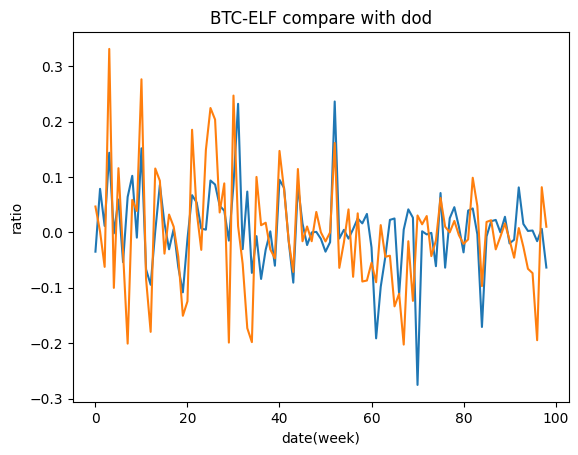

In [ ]:
plt.title("BTC-ELF compare with dod")
plt.xlabel('date(week)')
plt.ylabel('ratio')
timeLine =np.arange(0,99,1)
plt.plot(timeLine,BTC.dod,timeLine,ETH.dod )
plt.show()

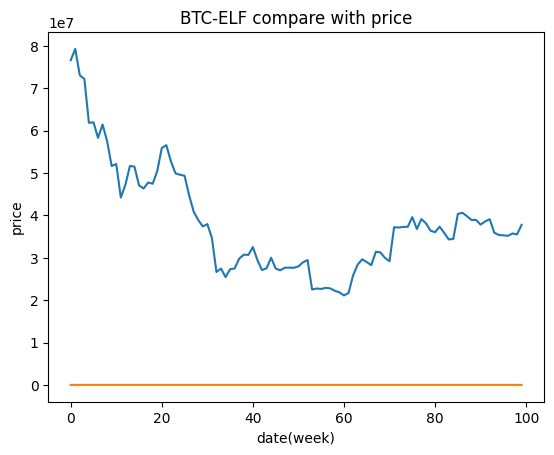

In [ ]:
plt.title("BTC-ELF compare with price")
plt.xlabel('date(week)')
plt.ylabel('price')
timeLine =np.arange(0,100,1)
plt.plot(timeLine,BTC.price,timeLine,ETH.price)
plt.show()

In [ ]:
BTC = compareDataPlot('week', 100, 'KRW-BAT')
ETH = compareDataPlot('week', 100, 'KRW-ANKR')
QTUM = compareDataPlot('week', 100, 'KRW-STORJ')

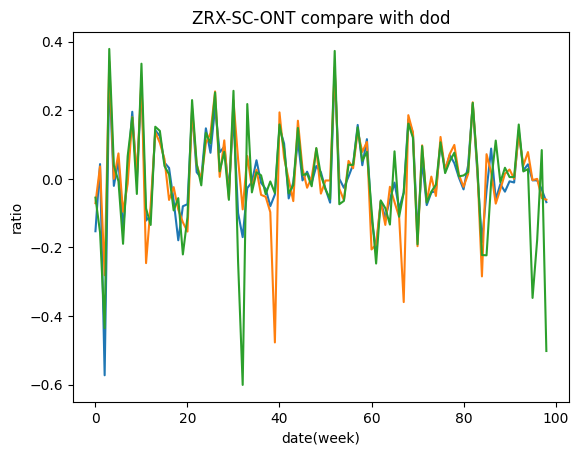

In [ ]:
plt.title("ZRX-SC-ONT compare with dod")
plt.xlabel('date(week)')
plt.ylabel('ratio')
timeLine =np.arange(0,99,1)
plt.plot(timeLine,BTC.dod,timeLine,ETH.dod, timeLine,QTUM.dod, )
plt.show()

<h1>API 생성을 위한 모듈화
--Class Part--

In [ ]:
from datetime import datetime

class pyCorrelUpbit:
  def __init__(self, ticker:str ,tickers):
    self.isCompleted = True
    self.interval = "day"
    self.to = datetime.now()
    self.count = 199
    self.ticker_main = ticker
    self. tickers_sub = tickers
    self.stocks:List[Stock] = field(default_factory=list)   #set()으로 변경해보기..
    self.define_tickers()

  def define_tickers(self):
    if type(self.tickers_sub) == str:
      self.tickers_sub = list(self.tickers_sub)

  # pyupbit에서 tickers 받아오고, main ticker와 sub tickers가 유효한지 검사 isCompleted = (...) ? True : False




  def getCorrelationFromTickers(self):
    df_main = pyupbit.get_ohlcv(ticker = self.ticker_main, interval = self.interval, to = self.to, count = self.count)
    open_main = df_main[['open']].values.flatten()
    for ticker_sub in self.tickers_sub:
      df_sub = pyupbit.get_ohlcv(ticker = ticker_sub, interval = self.interval, to = self.to, count = self.count)
      open_sub = df_sub[['open']].values.flatten()
      dod_sub =  []
      for i in range(1,self.count):
        dod_sub.append((open_sub[i-1] - open_sub[i])/open_sub[i-1])
        stocks.append(Stock(ticker_sub, dod_sub))
        #아직 코드 안끝남..




